In [14]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [15]:
train_data_path = 'dataset/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [16]:
train_df

,filepaths,label
0,dataset/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,dataset/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,dataset/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,dataset/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,dataset/Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,dataset/Training/meningioma/Tr-me_1053.jpg,meningioma
5708,dataset/Training/meningioma/Tr-me_0403.jpg,meningioma
5709,dataset/Training/meningioma/Tr-me_0365.jpg,meningioma
5710,dataset/Training/meningioma/Tr-me_0371.jpg,meningioma


In [17]:
test_data_path = 'dataset/Training'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [18]:
test_df

,filepaths,label
0,dataset/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,dataset/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,dataset/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,dataset/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,dataset/Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,dataset/Training/meningioma/Tr-me_1053.jpg,meningioma
5708,dataset/Training/meningioma/Tr-me_0403.jpg,meningioma
5709,dataset/Training/meningioma/Tr-me_0365.jpg,meningioma
5710,dataset/Training/meningioma/Tr-me_0371.jpg,meningioma


In [19]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [20]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.


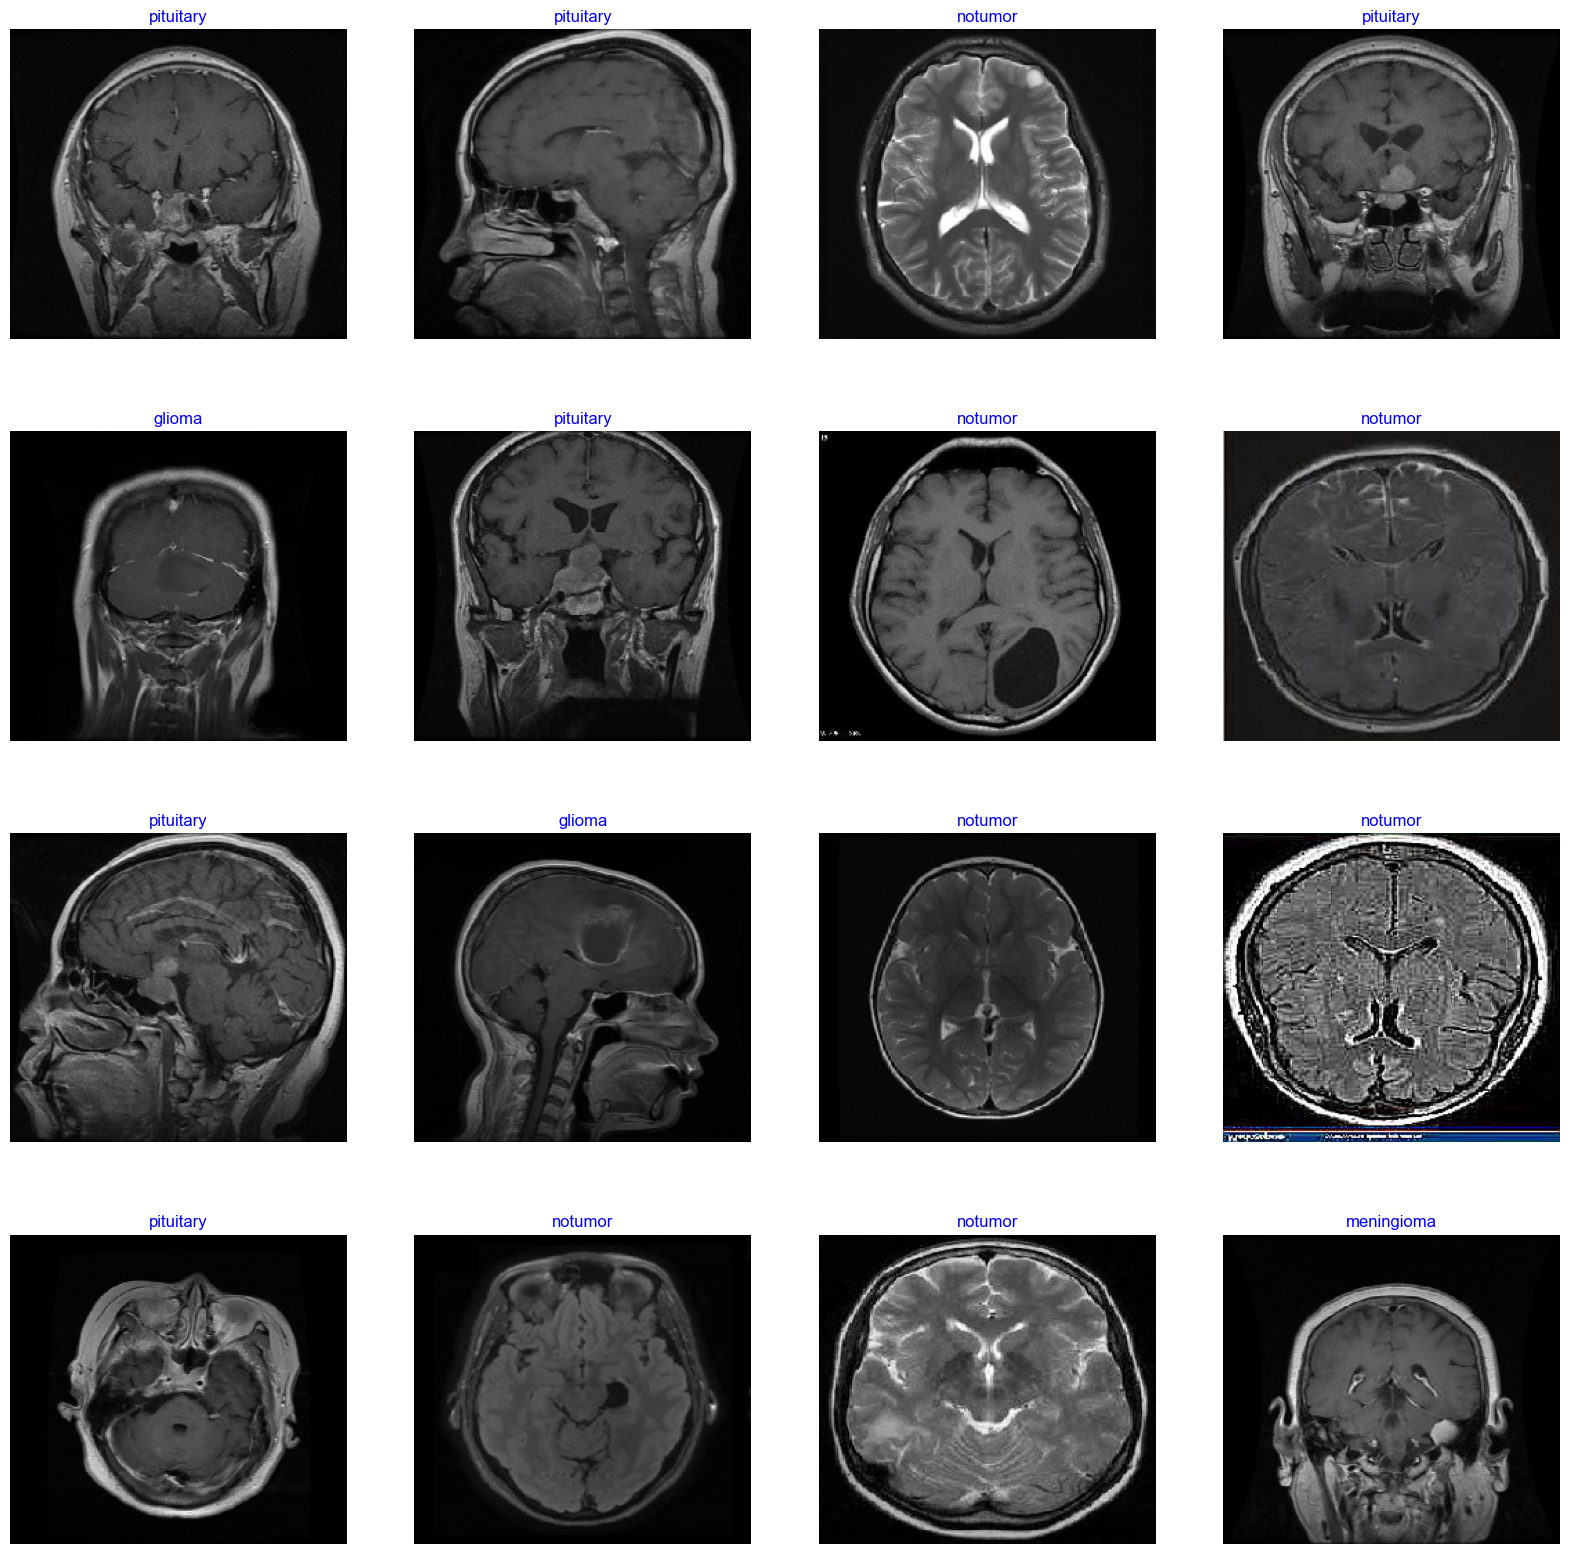

In [21]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [24]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

# base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
#                                                                input_shape = img_shape, pooling= 'max')
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 6,253,396
Trainable params: 6,190,228
No

Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

In [25]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

NameError: name 'history' is not defined

In [26]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 4s 234ms/step - loss: 12.3996 - accuracy: 0.2617
Train Loss:  12.0925874710083
Train Accuracy:  0.3046875
--------------------
Validation Loss:  12.035917282104492
Validation Accuracy:  0.25
--------------------
Test Loss:  12.399619102478027
Test Accuracy:  0.26171875


In [39]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

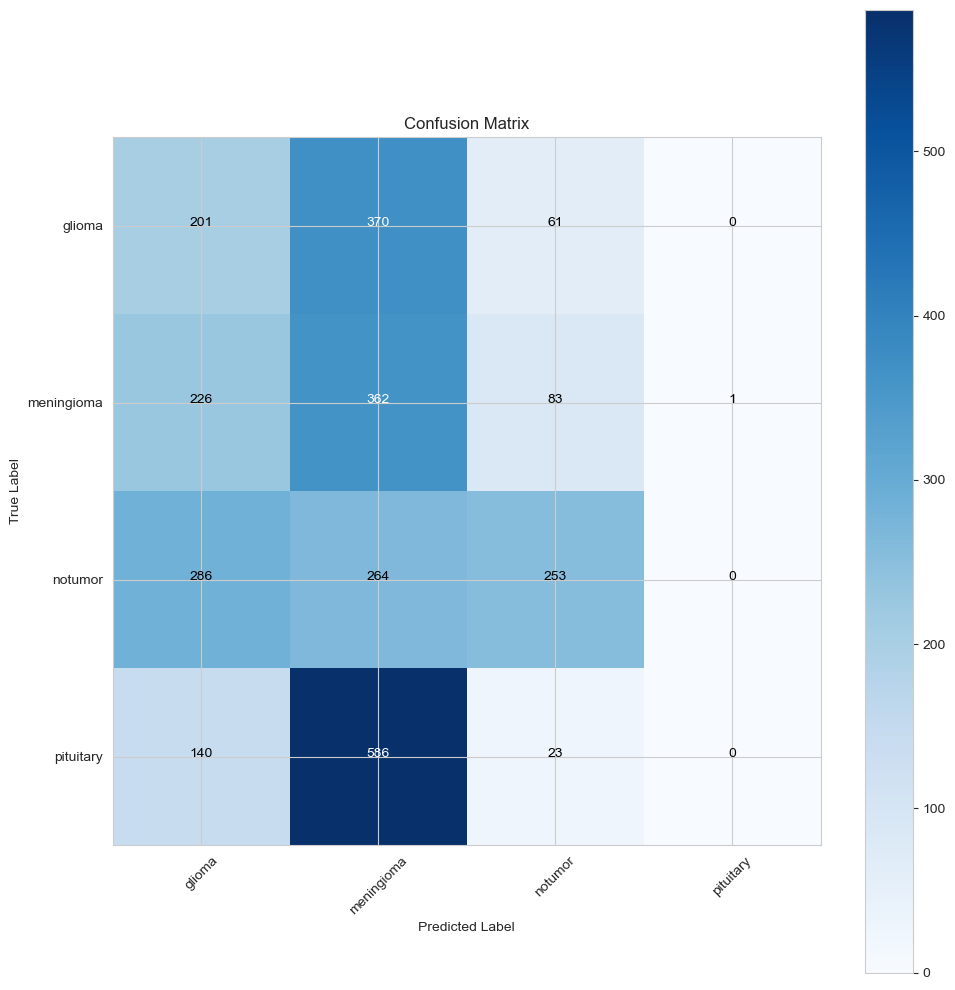

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [29]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.24      0.32      0.27       632
  meningioma       0.23      0.54      0.32       672
     notumor       0.60      0.32      0.41       803
   pituitary       0.00      0.00      0.00       749

    accuracy                           0.29      2856
   macro avg       0.27      0.29      0.25      2856
weighted avg       0.28      0.29      0.25      2856



In [22]:
model.save("model.h5")

In [31]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np



In [40]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
gambar = tf.keras.preprocessing.image.load_img('./tes4.jpg', target_size=img_size)

In [42]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [43]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

1/1 [==============================] - 1s 868ms/step


In [44]:
print(predicted_class)

[3]


In [45]:
names = [classes[i] for i in predicted_class]
print(names)

['pituitary']


In [46]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
